In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from scipy.optimize import curve_fit

plt.style.use("ggplot")

# Titration curves

Titration curves linking pH to CaCO3 (equivalent) concentrations for water with different levels of TOC.

Based on empirical data collected by Atle Hindar (see e-mail from Øyvind K received 30.03.2023 at 12.37).

In [2]:
xl_path = r"../data/titration_curves_atle_hindar.xlsx"
df = pd.read_excel(xl_path)
df.head()

,TOC class (mg/l),CaCO3 (mg/l),pH
0,TOC ≤ 3,0.0,4.5
1,TOC ≤ 3,0.1,4.6
2,TOC ≤ 3,0.2,4.7
3,TOC ≤ 3,0.3,4.8
4,TOC ≤ 3,0.4,4.9


In [3]:
# Add "baseline" CaCO3 corresponding to pH 4.5
# See spreadsheet in e-mail from Øyvind K received 27.05.2024 at 10.17
baseline_caco3 = 0.5  # mg/l of CaCO3
df["CaCO3 (mg/l)"] = df["CaCO3 (mg/l)"] + baseline_caco3

## 1. Plot empirical data

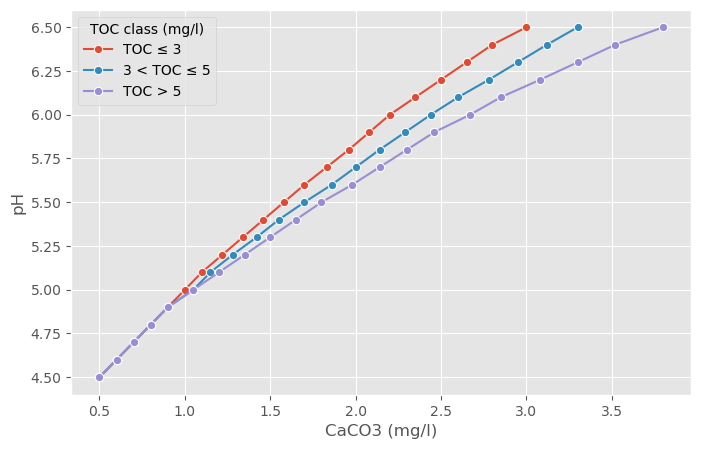

In [4]:
plt.figure(figsize=(8, 5))
ax = sn.lineplot(x="CaCO3 (mg/l)", y="pH", hue="TOC class (mg/l)", data=df, marker="o")

png_path = r"../docs/images/titration_curves.png"
plt.savefig(png_path, dpi=200)

Note that the curves are all identical below `0.4 + baseline` mg/l of CaCO3.

In order to use these curves in the model, I would like to extrapolate them beyond CaCO3 concentrations of ~3 mg/l. This is probably best done by fitting a sigmoid function to ensure the change in pH levels off as CaCO3 becomes higher. However, fitting an unconstrained sigmoid to each empirical dataset creates some issues. In particular, the fitted curves cross at both low and high concentrations of CaCO3, which is presumably not correct. 

I can prevent the curves crossing at high concentrations by manually defining an upper asympote for all the curves to approach. Øyvind Kaste has provided some analysis based on measured data in the referanseelver, plus lakes in Innlandet, Agder, Rogaland and Vestland (see e-mail received 27.05.2024 at 10.17). Despite a lot of natural variation in real lakes, there is reasonably clear evidence that the curves level off at around pH 7.5. To prevent the curves crossing at low concentrations, I will only fit the sigmoids to CaCO3 data > `0.4 + baseline` mg/l. I will then manually add a straight line segment extending to the point (`baseline`, 4.5). 

The code below does the following:

 1. Fits a sigmoid curve to each titration dataset, but only considering CaCO3 concentrations above `0.4 + baseline` mg/l and with a user-defined asymptote at pH = 7.5.
 
 2. Interpolates values using the fitted curve for a wide range of CaCO3 concentrations (far beyond Atle's measured data).
 
 3. Adds the point (CaCO3, pH) = (`baseline`, 4.5) to the start of each series in order to artificially clamp the curves to have the same relationship at low CaCO3 concentrations.

In [5]:
def sigmoid(x, x0, k):
    """Sigmoid function with asymptote at L."""
    y = L / (1 + np.exp(-k * (x - x0)))

    return y


def fit(xdata, ydata):
    """Fit constrained sigmoid to data."""
    # Initial guess for the parameters
    p0 = [np.median(xdata), 1]

    # Fit the curve
    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method="dogbox")

    return popt

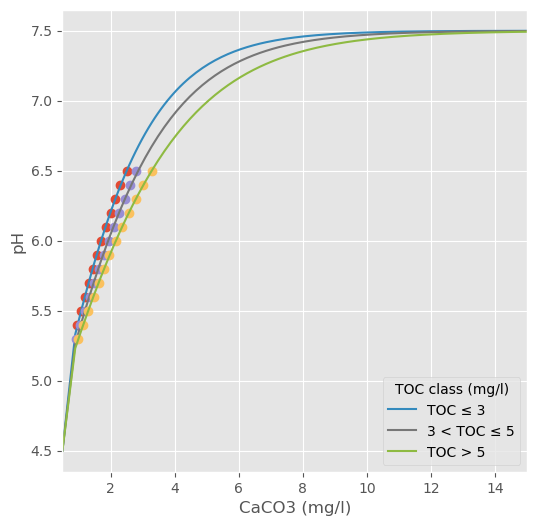

In [6]:
# User-specified asymptote
L = 7.5

# Read data from Excel file
xl_path = r"../data/titration_curves_atle_hindar.xlsx"
raw_df = pd.read_excel(xl_path)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

df_list = []
for toc_class in ["TOC ≤ 3", "3 < TOC ≤ 5", "TOC > 5"]:
    # Get empirical data above CaCO3 of (baseline + 0.4) mg/l
    df = raw_df.query(
        "(`TOC class (mg/l)` == @toc_class) and (`CaCO3 (mg/l)` > @baseline_caco3 + 0.4)"
    ).copy()
    xdata = df["CaCO3 (mg/l)"].values
    ydata = df["pH"].values
    popt = fit(xdata, ydata)

    # Predict values for broad range of CaCO3
    x = np.linspace(baseline_caco3 + 0.4, 100, 1000)
    y = sigmoid(x, *popt)

    # Add (baseline_caco3, 4.5) to start
    x = np.insert(x, 0, baseline_caco3)
    y = np.insert(y, 0, 4.5)

    # Build result dataframe
    res_df = pd.DataFrame({"CaCO3 (mg/l)": x, "pH": y})
    res_df["TOC class (mg/l)"] = toc_class
    res_df = res_df[df.columns]
    df_list.append(res_df)

    # Plot
    ax.plot(xdata, ydata, "o")
    ax.plot(x, y, label=toc_class)

ax.set_xlim(baseline_caco3, 15)
plt.xlabel("CaCO3 (mg/l)")
plt.ylabel("pH")
plt.legend(loc="lower right", title="TOC class (mg/l)")

# Combine
interp_df = pd.concat(df_list, axis="rows")

# Save
interp_xl_path = r"../data/titration_curves_interpolated.xlsx"
interp_df.to_excel(interp_xl_path, index=False)

png_path = r"../docs/images/titration_curves_interpolated.png"
plt.savefig(png_path, dpi=200)